In [97]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from settings import *
from itertools import compress

In [3]:
days = ['Day 1','Day 2']
target_lure = ['target','lure']
PSPC = ['PS','PC']
ABC = {'A':'Place','B':'Animal','C':'Object'}

In [4]:
onedrive_path = 'C:/Users/tuq67942/OneDrive - Temple University/Documents/Data/'
Sanity_Path = onedrive_path+'PSPC Sanity Check'
MDEM_path = onedrive_path+'Year 1/MDEM*/Sess*/*test*.csv'
xls = pd.ExcelFile('pspc_trialbytrial.xlsx')
Answer_dict = {}
Answer_dict['Day 1'] = pd.read_excel(xls,'B2_Item_status')
Answer_dict['Day 2'] = pd.read_excel(xls,'B1_Item_status')

In [5]:
# Need to code trial numbers into Answer key for B1_Item_status / Day 2 Answer_dict
# Column: "Trial_number"
day2df = pd.read_excel(xls,'B1_Item_status')
day2or = pd.read_excel(xls,'Block1_proc')
for test in day2df['List_type'].unique():
    if 'PS' in test:
        minior = day2or[day2or['List_type']==test]
        for i,(index, row) in enumerate(minior.iterrows()):
            images = [row.Image_1, row.Image_2, row.Image_3, row['Image 4']]
            for image in images:
                day2df.loc[(day2df['List_type'] == test) & (day2df['Test_image'] == image), 'Trial_number'] = i+1
Answer_dict['Day 2'] = day2df

In [6]:
xls = pd.ExcelFile('pspc_trialbytrial_KN.xlsx')
Answer_dictKN = {}
Answer_dictKN['Day 1'] = pd.read_excel(xls,'B2_Item_status')
Answer_dictKN['Day 2'] = pd.read_excel(xls,'B1_Item_status')

In [35]:
Sanity_dict = {}
results = []
for Day in days:
    Sanity_dict[Day] = {}
    for t in target_lure:
        Sanity_dict[Day][t] = \
        pd.read_csv(glob.glob(Sanity_Path+'/'+Day+'/test-'+t+'/*csv')[0]).dropna(subset=['Event']).reset_index()
        for test in PSPC:
            Answers = Answer_dict[Day][Answer_dict[Day]['List_type'].str.contains(test)]
            if test == 'PS':
                Sanity = Sanity_dict[Day][t].dropna(subset='ans')
                for answer in Sanity['ans']:
                    Type = Answers.loc[Answers['Test_image'] == answer]['List_type'].iloc[0].split('_')[1]
                    Status = Answers.loc[Answers['Test_image'] == answer]['Status'].iloc[0]
                    #Picture_correct = 
                    results.append({'Day':Day,'Target/Lure':t,'PSPC':test,'Type':Type,'Status':Status,\
                                    'Picture_chosen':answer})
            if test == 'PC':
                Sanity = Sanity_dict[Day][t].dropna(subset='PC_correct')
                for index, row in Sanity.iterrows():
                    answer = row.ans1
                    Status_temp = row.PC_correct
                    Status = 'target' if Status_temp else 'lure'
                    Type = Answers.loc[Answers['Test_image'] == answer]['List_type'].iloc[0].split('_')[1]
                    results.append({'Day':Day,'Target/Lure':t,'PSPC':test,'Type':Type,'Status':Status,\
                                    'Picture_chosen':answer})
resultdf = pd.DataFrame(results)
# re
results_sum = dict()
for d in resultdf['Day'].unique():
    for p in resultdf['PSPC'].unique():
        for t in resultdf['Type'].unique():
            new_df = resultdf[(resultdf['Day'] == d) & (resultdf['PSPC'] == p) & (resultdf['Type'] == t)]
            if len(new_df)>0:
                temp = dict(new_df['Status'].value_counts())
                for key in temp:
                    results_sum[' '.join([d,p,t,key])] = temp[key]

In [71]:
# Need to create a function to extract data from each participant 
def cal_results(files):
    # files are the Day 1 and Day 2 files
    results = []
    results_sum = dict()
    for f in files:
        Day = 'Day '+f.split(onedrive_path)[1].split('day')[1][0]
        df = pd.read_csv(f).dropna(subset=['Event']).reset_index()
        for test in PSPC:
            Answers = Answer_dict[Day][Answer_dict[Day]['List_type'].str.contains(test)]
            if test == 'PS':
                psdf = df.dropna(subset='ans')
                for answer in psdf['ans']:
                    Type = Answers.loc[Answers['Test_image'] == answer]['List_type'].iloc[0].split('_')[1]
                    Status = Answers.loc[Answers['Test_image'] == answer]['Status'].iloc[0]
                    #Picture_correct = 
                    results.append({'Day':Day,'PSPC':test,'Type':Type,'Status':Status,\
                                    'Picture_chosen':answer})
            if test == 'PC':
                pcdf = df.dropna(subset='PC_correct')
                for index, row in pcdf.iterrows():
                    answer = row.ans1
                    Status_temp = row.PC_correct
                    Status = 'target' if Status_temp else 'lure'
                    Type = Answers.loc[Answers['Test_image'] == answer]['List_type'].iloc[0].split('_')[1]
                    results.append({'Day':Day,'PSPC':test,'Type':Type,'Status':Status,\
                                    'Picture_chosen':answer})
        resultdf = pd.DataFrame(results)
        for d in resultdf['Day'].unique():
            for p in resultdf['PSPC'].unique():
                for t in resultdf['Type'].unique():
                    new_df = resultdf[(resultdf['Day'] == d) & (resultdf['PSPC'] == p) & (resultdf['Type'] == t)]
                    if len(new_df)>0:
                        temp = dict(new_df['Status'].value_counts())
                        for key in temp:
                            results_sum[' '.join([d,p,t,key])] = temp[key]
    return results_sum

In [9]:
data_tmp = glob.glob(MDEM_path)
data = []
# ensure that data for Day 1 and Day 2 are present
# save whether Day 1 and Day 2 were both during Session 1 or not
# a list of all subjects with data
for d in data_tmp:
    d_ = d.split('/')[-1].split('\\')[-1].split('_')[0]
    if os.path.getsize(d) > 50000:
        if sum(d_ in s for s in data_tmp) > 1:
            session_list = [s.split('/')[-1].split('\\')[2] for s in list(compress(data_tmp, [d_ in s for s in data_tmp]))]
            same_day = True if session_list[0]==session_list[1] else False
            dictionary = {'Subject':d_,'Same_Day':same_day}
            if dictionary not in data:
                data.append(dictionary)
datadf = pd.DataFrame(data)

In [10]:
# Download newest demographics spreadsheet from Redcap, and put in this folder
# Add age and sex demographics to datadf
demofiles = glob.glob(onedrive_path+'R01MarvelousMoments*')
demofile = max(demofiles, key=os.path.getctime)
df = pd.read_csv(demofile).dropna(subset = ['demo_age'])
df = df[['participant_id','demo_age','demo_child_gender']]
datadf = datadf.join(df.set_index('participant_id'), on='Subject')

In [72]:
for index, row in datadf.iterrows():
    subject = row.Subject
    files = glob.glob(onedrive_path+'Year 1/'+subject+'/Sess*/*test*.csv')
    files = [f for f in files if os.path.getsize(f) > 50000]
    results_sum = cal_results(files)
    for key in results_sum:
        if key not in datadf:
            datadf[key] = 0
        datadf.loc[index, key] = results_sum[key]
    

28it [00:05,  4.71it/s]


In [121]:
datadf = datadf.rename({'demo_age': 'Age', 'demo_child_gender': 'Gender','Same_Day':'Same Day'}, axis='columns')
# summary columns:
datadf['Day 1 PS Target'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PS' in d and 'target' in d]].sum(axis=1)
datadf['Day 2 PS Target'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PS' in d and 'target' in d]].sum(axis=1)
datadf['Day 1 PS Lure'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PS' in d and 'lure' in d]].sum(axis=1)
datadf['Day 2 PS Lure'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PS' in d and 'lure' in d]].sum(axis=1)

datadf['Day 1 PC Target'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PC' in d and 'target' in d]].sum(axis=1)
datadf['Day 2 PC Target'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PC' in d and 'target' in d]].sum(axis=1)
datadf['Day 1 PC Lure'] = datadf[[d for d in datadf.columns if 'Day 1' in d and 'PC' in d and 'lure' in d]].sum(axis=1)
datadf['Day 2 PC Lure'] = datadf[[d for d in datadf.columns if 'Day 2' in d and 'PC' in d and 'lure' in d]].sum(axis=1)

datadf['PS Target'] = datadf[[d for d in datadf.columns if 'PS' in d and 'target' in d]].sum(axis=1)
datadf['PS Lure'] = datadf[[d for d in datadf.columns if 'PS' in d and 'lure' in d]].sum(axis=1)
   
datadf['PC Target'] = datadf[[d for d in datadf.columns if 'PC' in d and 'target' in d]].sum(axis=1)
datadf['PC Lure'] = datadf[[d for d in datadf.columns if 'PC' in d and 'lure' in d]].sum(axis=1)
         

Text(0.5, 1.0, 'Age and Gender Histogram')

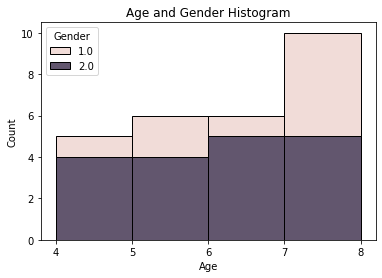

In [107]:
g = sns.histplot(data=datadf, x="Age", hue="Gender", multiple="stack",bins=np.arange(4,9))
g.set_xticks(np.arange(4,9)) # <--- set the ticks first
g.set_xticklabels(np.arange(4,9))
g.set_title('Age and Gender Histogram')

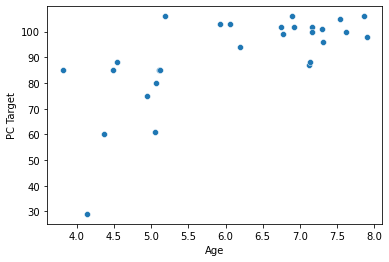

In [118]:
g = sns.scatterplot(data=datadf,  x='Age', y='PC Target')

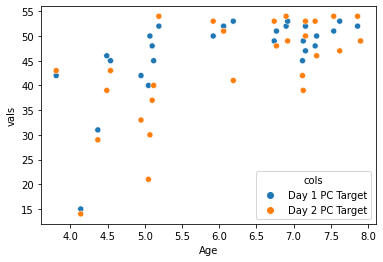

In [117]:
temp = datadf[['Age', 'Day 1 PC Target','Day 2 PC Target']]
dfm = temp.melt('Age', var_name='cols', value_name='vals')
g = sns.scatterplot(x="Age", y="vals", hue='cols', data=dfm)

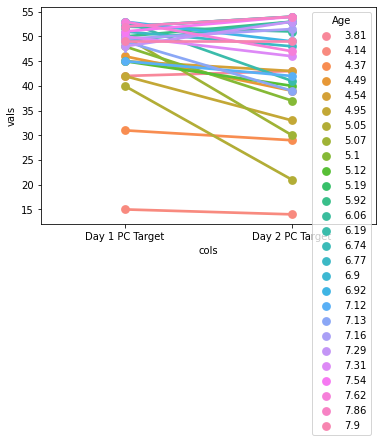

In [128]:
temp = datadf[['Age', 'Day 1 PC Target','Day 2 PC Target']]
dfm = temp.melt('Age', var_name='cols', value_name='vals')
g = sns.pointplot(x="cols", y="vals", hue='Age', data=dfm)

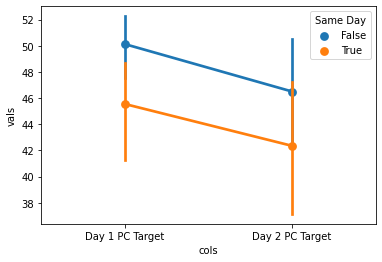

In [129]:
temp = datadf[['Same Day', 'Day 1 PC Target','Day 2 PC Target']]
dfm = temp.melt('Same Day', var_name='cols', value_name='vals')
g = sns.pointplot(x="cols", y="vals", hue='Same Day', data=dfm)

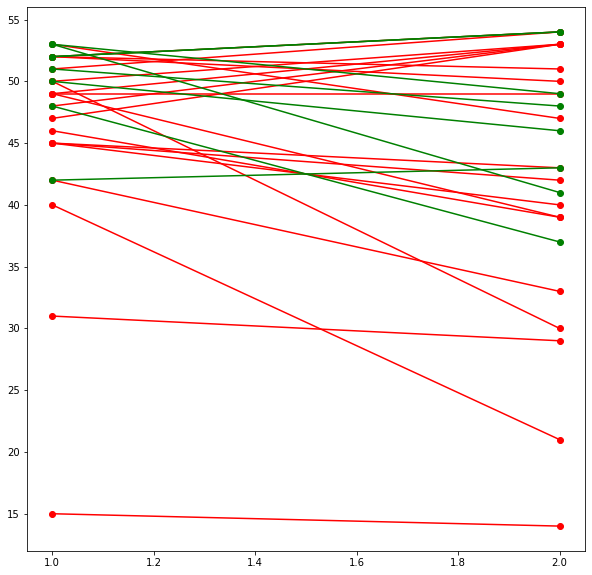

In [145]:
fig = plt.figure(figsize =(10, 10))

c = ['r','g']
for i,sd in enumerate([True,False]):
    tmp = datadf[datadf['Same Day'] == sd]
    for ii in range(len(tmp)):
        plt.plot([1,2],[tmp['Day 1 PC Target'].iloc[ii], tmp['Day 2 PC Target'].iloc[ii]],'o-',color = c[i])
plt.show()

C:\Users\tuq67942\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tuq67942\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tuq67942\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tuq67942\Anac

<AxesSubplot:xlabel='PS Lure'>

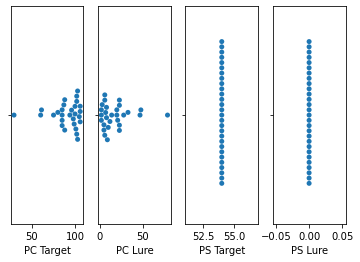

In [154]:
fig, ax =plt.subplots(1,4)
sns.swarmplot(datadf['PC Target'], ax=ax[0])
sns.swarmplot(datadf['PC Lure'], ax=ax[1])
sns.swarmplot(datadf['PS Target'], ax=ax[2])
sns.swarmplot(datadf['PS Lure'], ax=ax[3])